# Adverserial Optimization in Geomorphology

In [1]:
import numpy as np
import xarray as xr
import xsimlab
import torch
import matplotlib.pyplot as plt

from multiprocessing import Pool
from xtopo.models import fastscape_base_model

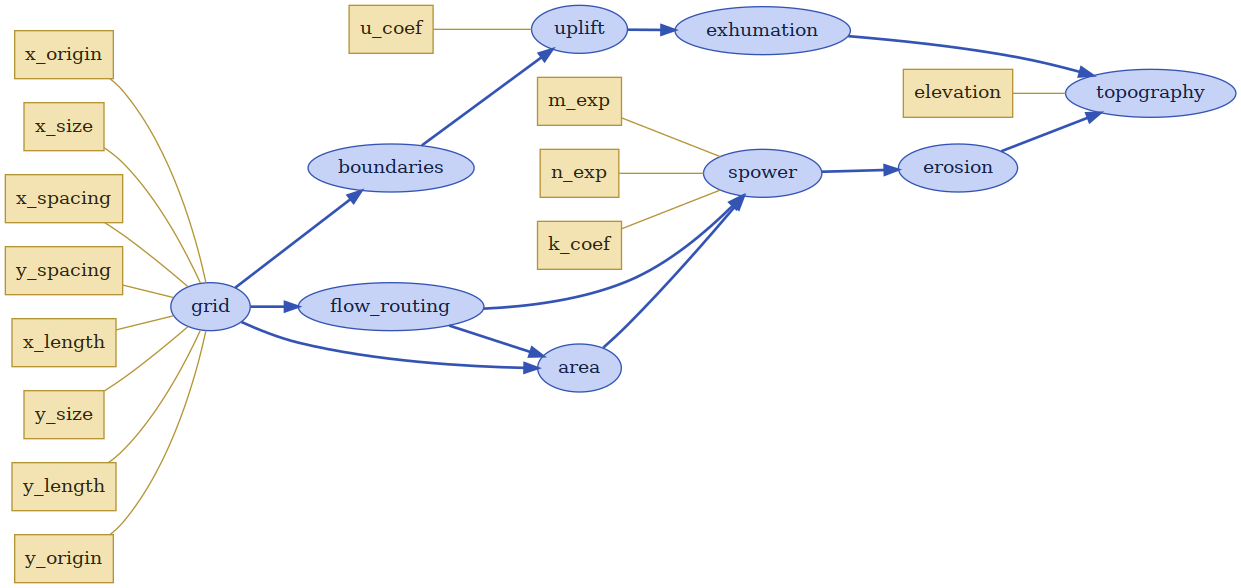

In [2]:
fastscape_base_model.visualize(show_inputs=True)

In [3]:
def simulate(theta, num_x=101, num_y=101, num_samples=1, parallelization=128):
    # Theta is defined as:
    # spower_k_coef
    # spower_m_exp
    # spower_n_exp
    # uplift_u_coef
    # Prepare an empty list of initial configurations.
    configurations = []
    # Prepare a set of configurations.
    for i in range(0, num_samples):
        # Define the xsimlab model setup.
        in_dataset = xsimlab.create_setup(
            model=fastscape_base_model,
            clocks = {
                'time': {'end': 1e6, 'step': 1e3},
                'out': {'end': 1e6, 'step': 1e5}
            },
            master_clock='time',
            input_vars={
                'grid': {'x_size': num_x, 'y_size': num_y, 
                         'x_length': 1e5, 'y_length' :1e5},
                'topography': {'elevation': ('node', np.random.rand(num_x * num_y))},
                'spower': {'k_coef': theta[0], 'm_exp': theta[1], 'n_exp': theta[2]},
                'uplift': {'u_coef': theta[3]}
            },
            snapshot_vars={
                'out': {'topography': 'elevation'},
                None: {'grid': ('x', 'y')}
            }
        )
        # Append to configuration.
        configurations.append(in_dataset)
    # Put the pool to work.
    with Pool(parallelization) as p:
        samples = p.map(simulation_run, configurations)
        
    return np.asarray(samples)


def simulation_run(configuration):
    # Apply the simulation.
    out_dataset = (configuration.xsimlab.run(model=fastscape_base_model)
                   .set_index(node=['grid__x', 'grid__y'])
                   .unstack('node'))
    # Fetch the produced matrix.
    matrix = out_dataset.isel(out=-1).topography__elevation.T
    
    return matrix.data

In [4]:
theta = [7e-5, .4, 1., 2e-3]
samples = simulate(theta, num_x=201, num_y=201, num_samples=100)

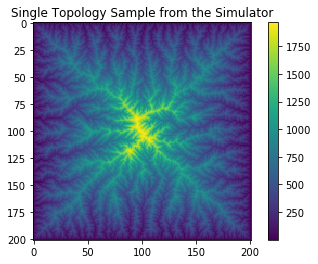

In [6]:
plt.title("Single Topology Sample from the Simulator")
plt.imshow(samples[0])
plt.colorbar()
plt.show()

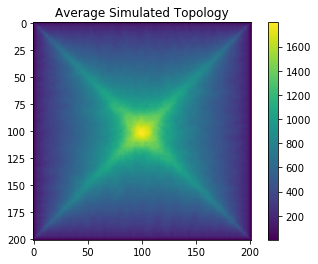

In [5]:
plt.title("Average Simulated Topology")
plt.imshow(samples.mean(0))
plt.colorbar()
plt.show()